In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import pprint


In [2]:
#from sklearn.cluster import DBSCAN, KMeans, OPTICS, SpectralClustering
from sklearn.cluster import  KMeans,  SpectralClustering # DBSCAN, OPTICS,
import umap
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.decomposition import PCA

def create_tree_by_cluster_knn_mst(X, n_clusters='sqrt', n_neighbors= 10,   verbose =  0, clustering_method = 'Kmeans' ):
  '''
  # Calcuates a tree approximation for given dataset X, by kmeans+knn+mst
  # 
  #' @param n_clusters number of clusters for clustering or 'sqrt' - square root of dataset size
  #' @param n_neighbors used by knn-graph step
  #
  #' @return
  # dict_result - dictionary with results:
  #   dict_result['csr_mst'] # adjancy matrix of MST graph in csr format (column sparse matrix - scipy )
  #   dict_result['edges_mst'] # edges matrix of MST graph, shape = n_nodes X 2 , each row contains ends of the correspoding edges
  #   dict_result['nodes_positions']  graph nodes positions
  #   dict_result['predicted_clusters'] vector with cluster number for each point of  input X
  #   dict_result['csr_knn'] same as 'csr_mst', but for intermediate knn-graph  
  #   dict_result['edges_knn'] same as 'edges_mst', but for intermediate knn-graph 
  # 
  #' @examples
  # X = np.random.rand(1000,10)
  # dict_result =  create_tree_by_cluster_knn_mst(X)# - Calcuates a tree for given dataset, by kmeans+knn+mst
  # edges =  dict_result['edges_mst']
  # nodes_positions = dict_result['nodes_positions']
  # plot_graph(edges, nodes_positions, data = X)
  # plt.show()  
  '''
  if n_clusters == 'sqrt':
    n_clusters = int( np.sqrt(X.shape[0] ) ) 

  #print("clustering_method.lower() == 'Spectral'.lower()", clustering_method.lower() == 'Spectral'.lower() )
  if isinstance(clustering_method ,str) and ( clustering_method.lower() == 'Spectral'.lower() ):
    clustering = SpectralClustering(n_clusters=n_clusters, random_state=0).fit(X)
    predicted_clusters = clustering.labels_ # kmeans.predict(X)
    # Get cluster centers by averaging:
    l = len(np.unique(predicted_clusters))
    cluster_centers_ = np.zeros( (l, X.shape[1]))
    for i,v in  enumerate(np.unique(predicted_clusters)):
      m = predicted_clusters==v 
      cluster_centers_[i,:] = np.mean(X[m,:],axis = 0 )
  else: # Kmeans clustering by defualt:
    clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    cluster_centers_ = clustering.cluster_centers_
  predicted_clusters = clustering.labels_ # kmeans.predict(X)

  if verbose >= 100:
    print('cluster_centers_[:2,:]', cluster_centers_[:2,:])
    print('predicted_clusters.shape', predicted_clusters.shape)
    print('predicted_clusters[:2]', predicted_clusters[:2])

  # sklearn.neighbors.kneighbors_graph(X, n_neighbors, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False, n_jobs=None)[source]¶
  if n_neighbors > len(cluster_centers_):
    n_neighbors = len(cluster_centers_) # To avoid exception for small number of clusters 
  csr_knn = kneighbors_graph(cluster_centers_, n_neighbors= n_neighbors, mode= 'distance', include_self=True) # mode=  'connectivity'
  if verbose >= 100:
    print('csr_knn', type(csr_knn), csr_knn.shape)

  csr_mst = minimum_spanning_tree(csr_knn)
  if verbose >= 100:
    print('csr_mst', type(csr_mst),csr_mst.shape)

  dict_result = {}
  dict_result['csr_mst'] = csr_mst
  dict_result['csr_knn'] = csr_knn
  dict_result['nodes_positions'] = cluster_centers_
  dict_result['predicted_clusters'] = predicted_clusters
  dict_result['edges_mst'] = get_edges_from_adj_matrix( csr_mst )
  dict_result['edges_knn'] = get_edges_from_adj_matrix( csr_knn )

  return dict_result

def get_edges_from_adj_matrix( adj_matrix ):
  '''
  #' From adjacency matrix construct an edge list
  #' either [k1,k2]!=0 or [k2,k1]!=0, causes edge (k1,k2)
  #'
  #' @param  adj_matrix - adjacency matrix of an unoriented graph
  #'
  #' @return numpy.ndarray of shape Nx2, containing vertices for each edge 
  #'    
  #' @examples
  #' adj_matrix = np.array([[0,1,1],[0,0,0],[0,2,0]])
  #' edges = get_edges_from_adj_matrix( adj_matrix )
  '''
  list_edges = []
  n_vertex = adj_matrix.shape[0]
  for k1 in range(  n_vertex  ) :
    for k2 in range(k1, n_vertex ) :
      if ( adj_matrix[k1,k2] != 0) or (adj_matrix[k2,k1] != 0):
          list_edges.append( (k1,k2) )
  return np.array(list_edges)

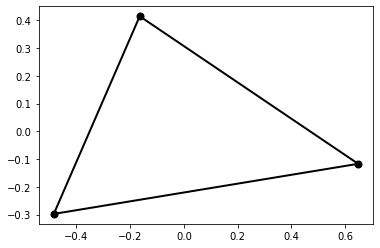

In [3]:
from sklearn.decomposition import PCA
try :
    import umap
except:
    print('cannot import umap')

def plot_graph(edges, nodes_positions, data = None, dim_reduction = 'PCA', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = 'tab:red', data_transparency_alpha = 0.9,
               umap_n_neighbors = 50, umap_min_dist = 0.99):
  '''
  #' Plots graphs defined by edges and nodes_positions, optionally - scatter plot the "data" on the same plot,
  #' Optionally performs PCA/etc (depending on dim_reduction)
  #'
  #' @param edges Nx2-shape matrix with edges ends, i.e. edges[k,0], edges[k,1] - ends of k-th edge  
  #' @param nodes_positions  matrix of nodes positions 
  #' @param data  "original dataset", basically arbitrary dataset for scatter plot, it should have same shape[1] as nodes_positions
  #' @param plot_data  True/False - to scatterplot or not data
  #' @param dim_reduction  'PCA', 'plot_first2axis', 'umap'
  #' @param data_color can be a vector or predefined color - argument for c = data_color in scatter

  #' @examples
  # edges = np.array([ [0,1],[1,2],[2,0] ] )
  # nodes_positions = np.random.rand(3,10) # 3 points in 10d space
  # plot_graph(edges, nodes_positions)
  #
  # t = elpigraph_output
  # edges = t[0]['Edges'][0]
  # nodes_positions = t[0]['NodePositions']
  # plot_graph(edges, nodes_positions)
  '''
  str_dim_reduction = dim_reduction
  if dim_reduction in ['PCA', 'umap' ]: #  not 'plot_first2axis':
    if dim_reduction.upper() == 'PCA':
      reducer = PCA()
    elif dim_reduction.lower() == 'umap':
      n_neighbors = umap_n_neighbors#  50
      min_dist= umap_min_dist # 0.99
      #n_components=n_components
      reducer = umap.UMAP( n_neighbors=n_neighbors,        min_dist=min_dist, n_components = 2)

    if data is not None:
      data2 = reducer.fit_transform(data)
      if plot_data == True:
        if data_color is None:
          plt.scatter(data2[:,0],data2[:,1], linewidth = data_linewidth , alpha = data_transparency_alpha)# ,cmap=plt.cm.Paired) # ,c=np.array(irx) 
          plt.xlabel(str_dim_reduction+'1')
          plt.ylabel(str_dim_reduction+'2')
        else:
          plt.scatter(data2[:,0],data2[:,1] ,cmap=plt.cm.Paired,c= data_color, linewidth = data_linewidth, alpha = data_transparency_alpha ) 
          plt.xlabel(str_dim_reduction+'1')
          plt.ylabel(str_dim_reduction+'2')
    else:
      reducer.fit(nodes_positions)

    nodes_positions2 = reducer.transform( nodes_positions )
  else:
    if plot_data == True:
      if data is not None:
        if data_color is None:
          plt.scatter(data[:,0],data[:,1] , linewidth = linewidth, alpha = data_transparency_alpha )# ,cmap=plt.cm.Paired) # ,c=np.array(irx) 
        else:
          plt.scatter(data[:,0],data[:,1] ,cmap=plt.cm.Paired,c= data_color , linewidth = data_linewidth, alpha = data_transparency_alpha ) 
    nodes_positions2 = nodes_positions

  plt.scatter(nodes_positions2[:,0],nodes_positions2[:,1],c = graph_color, linewidth = graph_linewidth)#, cmap=plt.cm.Paired)

  edgeCount = edges.shape[0]
  for k in range(edgeCount):
    n0 = edges[k,0]
    n1 = edges[k,1]
    x_line = [ nodes_positions2[n0,0],  nodes_positions2[n1,0] ]
    y_line = [ nodes_positions2[n0,1],  nodes_positions2[n1,1] ]
    plt.plot(x_line, y_line, graph_color, linewidth = graph_linewidth) # 'black')

    
edges = np.array([ [0,1],[1,2],[2,0] ] )
nodes_positions = np.random.rand(3,10) # 3 points in 10d space
plot_graph(edges, nodes_positions)    

# Examples of MST trajectories on different dataset 

## Random uniform data in various dimensions

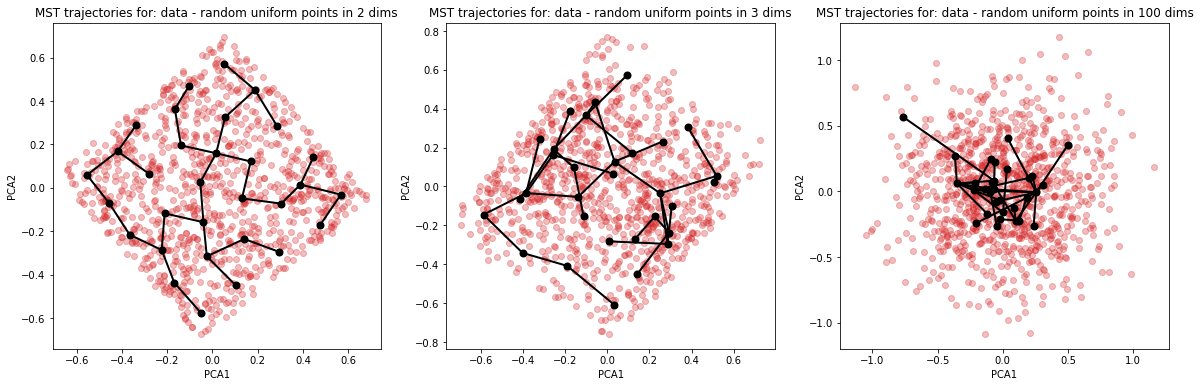

In [4]:
fig = plt.figure(figsize=(20, 6))
n_subplots_x = 3
c = 0

for dim in [2,3,100]:
    c+=1; fig.add_subplot(1, n_subplots_x , c) 
    X = np.random.rand(1000,dim )
    dict_result =  create_tree_by_cluster_knn_mst(X)# - Calcuates a tree for given dataset, by kmeans+knn+mst
    edges =  dict_result['edges_mst']
    nodes_positions = dict_result['nodes_positions']
    plot_graph(edges, nodes_positions, data = X, dim_reduction = 'PCA', data_transparency_alpha = 0.3 )
    plt.title('MST trajectories for: data - random uniform points in '+str(dim)+' dims')

plt.show()  

## Dumbell like data - tree 5 edges 2 branch points

(600, 2) (600,)


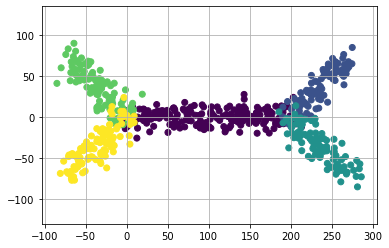

In [5]:
def make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] ):
  '''
  '''

  """
  n_layers = 2
  n_features = 2
  sigma_noise = 10.0
  plot_mode = 'PCA'
  n_samples4base = 200
  n_samples4branches = [100,100,100,100]
  angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4]
  """

  X_noiseless = np.zeros( (0,n_features))
  y_final = np.zeros( 0 )
  for layer in range(n_layers):
    current_label = 0 
    X = np.zeros( (n_samples4base, n_features) )
    X[:,0] = np.arange(n_samples4base)
    y = current_label * np.ones( n_samples4base )
    v_last_base_point_save = X[-1,:].copy()
    v_first_base_point_save = X[0,:].copy()

    # Make branches
    n_branches = len ( n_samples4branches )
    for c_branch in range( n_branches ) : # n_branches
      n_sample4branch = n_samples4branches[c_branch]
      current_label += 1
      y_branch = current_label * np.ones( n_sample4branch )
      angle = angles[c_branch] 
      if c_branch < n_branches/ 2:
        v_initial = v_last_base_point_save
      else:
        v_initial = v_first_base_point_save  
      X_branch = np.zeros( (n_sample4branch,  n_features)  ) #  [:2] = (np.cos(angle), np.sin(angle) )  
      v_direction = np.zeros( n_features)
      v_direction[0] = np.cos(angle)
      v_direction[1] = np.sin(angle)
      X_branch += v_direction # Broadcast vector to the whole array over axis 0 
      X_branch *= np.arange( 1, X_branch.shape[0] +1 ).reshape(X_branch.shape[0], 1 ) # Broadcast - mutiply each column by  by column = 1,2,3, ... 
      X_branch += v_initial # 
      X = np.concatenate( (X,X_branch) , axis = 0 )
      y = np.concatenate( (y, y_branch ))
    X_noiseless = np.concatenate( (X_noiseless,X) , axis = 0 )
    y_final = np.concatenate( (y_final,y) ) 
    
  X_noisy = X_noiseless + sigma_noise * np.random.randn( X_noiseless.shape[0], X_noiseless.shape[1] )


  y = y_final
  X = X_noisy

  if 0:
    print(X.shape, y.shape)
    r = X_noisy
    plt.scatter(r[:,0],r[:,1], c =y)
    plt.show()
  
  return X,y

X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )
if 1:
  print(X.shape, y.shape)
  r = X
  plt.scatter(r[:,0],r[:,1], c =y)
  plt.axis("equal")
  plt.grid()
  plt.show()


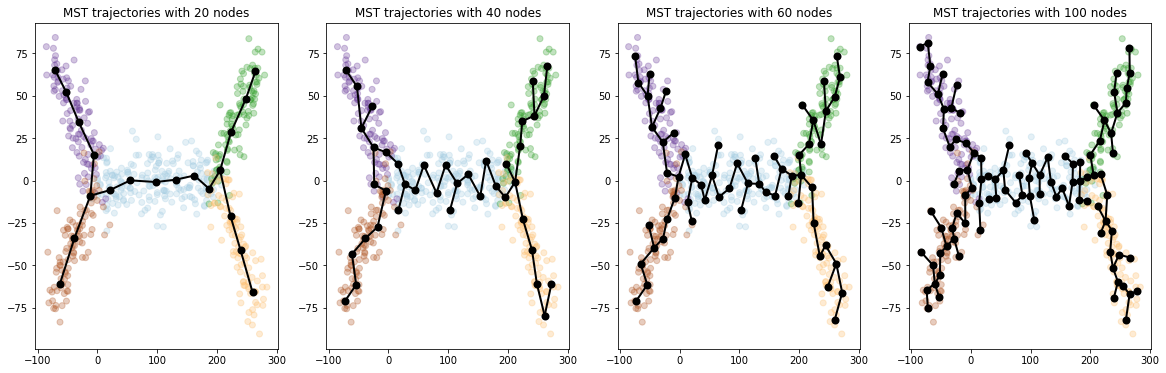

<Figure size 1440x432 with 0 Axes>

In [6]:
X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )

fig = plt.figure(figsize=(20, 6))
c = 0
list_nodes_number =[20,40,60,100 ] #  [2,3,4,5,6,7,8,9,10,20,30,40,50, 60, 100, 200 ]
n_subplots_x = len(list_nodes_number)

for nodes_number in list_nodes_number:
    c+=1; fig.add_subplot(1, 4 , c ) 
    dict_result =  create_tree_by_cluster_knn_mst(X, n_clusters= nodes_number )# - Calcuates a tree for given dataset, by kmeans+knn+mst
    edges =  dict_result['edges_mst']
    nodes_positions = dict_result['nodes_positions']
    plot_graph(edges, nodes_positions, data = X, dim_reduction = 'plot_first2axis', data_transparency_alpha = 0.3 , data_color = y)
    plt.title('MST trajectories with '+str(nodes_number)+' nodes')
    if (c%4 == 0) :
        plt.show() 
        fig = plt.figure(figsize=(20, 6))
        c = 0
         
        
plt.show()  

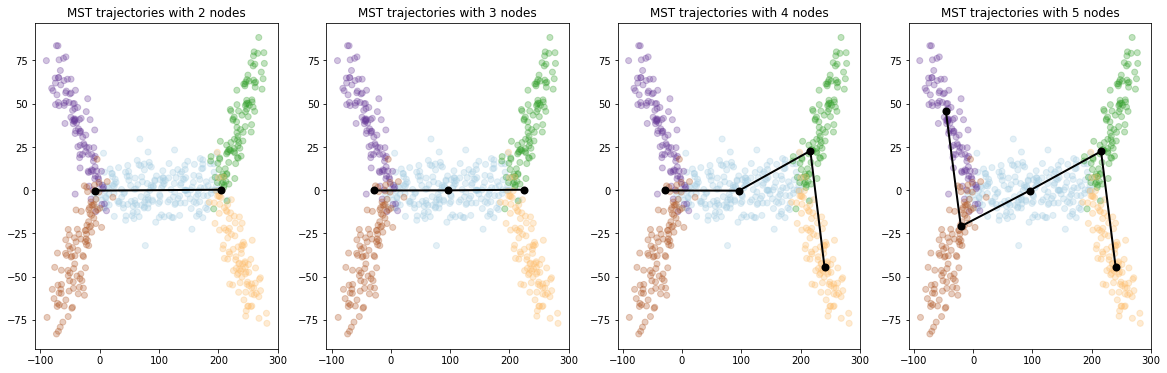

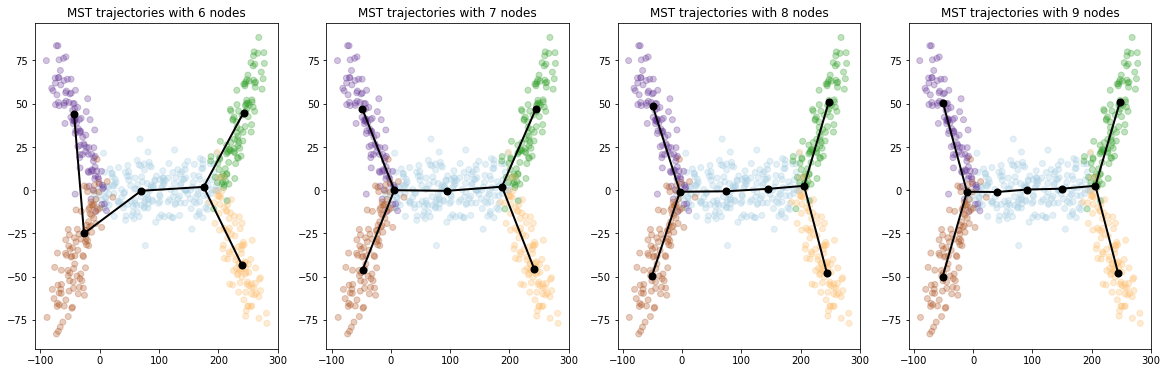

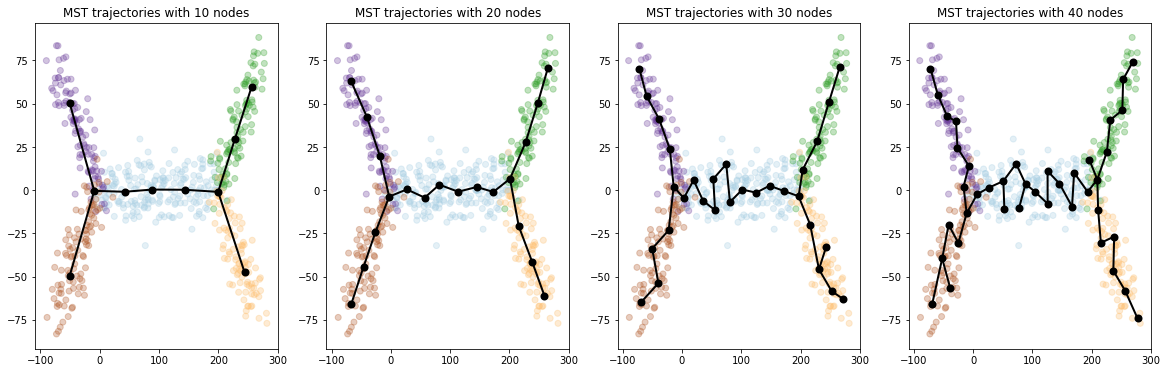

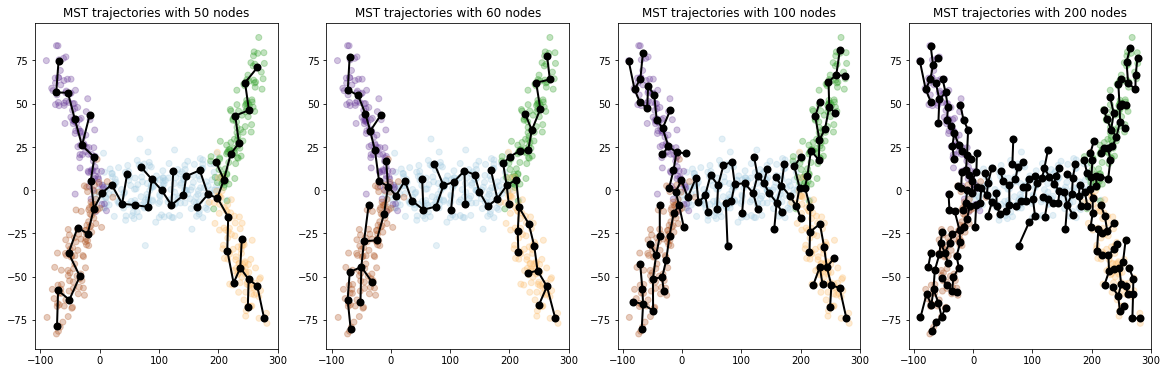

<Figure size 1440x432 with 0 Axes>

In [7]:
X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )

fig = plt.figure(figsize=(20, 6))
c = 0
list_nodes_number = [2,3,4,5,6,7,8,9,10,20,30,40,50, 60, 100, 200 ]
n_subplots_x = len(list_nodes_number)

for nodes_number in list_nodes_number:
    c+=1; fig.add_subplot(1, 4 , c ) 
    dict_result =  create_tree_by_cluster_knn_mst(X, n_clusters= nodes_number )# - Calcuates a tree for given dataset, by kmeans+knn+mst
    edges =  dict_result['edges_mst']
    nodes_positions = dict_result['nodes_positions']
    plot_graph(edges, nodes_positions, data = X, dim_reduction = 'plot_first2axis', data_transparency_alpha = 0.3 , data_color = y)
    plt.title('MST trajectories with '+str(nodes_number)+' nodes')
    if (c%4 == 0) :
        plt.show() 
        fig = plt.figure(figsize=(20, 6))
        c = 0
         
        
plt.show()  

## Tree like - 7 edges 3 branch points

(1050, 20) shape of output array X. (1050,) shape of output y
(1050, 20) (1050,)
[[ 149.            0.        ]
 [ 268.22407759   90.36585046]
 [ 156.11517562 -149.83424469]]


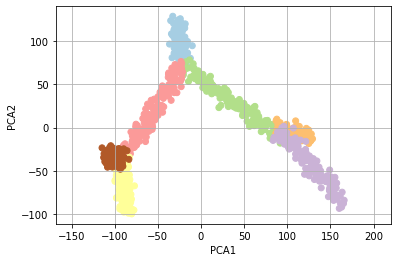

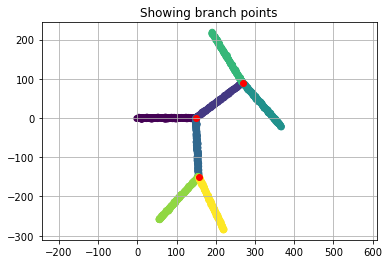

In [8]:
from sklearn.decomposition import  PCA

try:
    import umap 
except:
    print('cannot import umap - do not use plot_mode = "umap"')

def make_multi_level_fork(n_teeth = 2, len_tooth=100,
        n_components = 2, n_levels_of_branching = 2, inertia_coef = 0, 
        sigma_noise = 10.0,  teeth_start_distance = 0,  plot_mode = 'PCA',
        step_from_previous_branch = 0 , return_X_y = True ): 
  '''
  Returns numpy array containing image for multi-teeth fork,
  its shape is (len_tooth*(n_teeth+1) , 2  ) , 
  output y  - contains labels, which is teath number and zero for base of the fork
  
  @examples
  X = make_multi_level_fork()
  X = makemake_multi_level_fork_fork(n_teeth = 3, plot_mode = 'PCA' )
  '''

  """
  n_components = 5
  n_levels_of_branching = 2
  inertia_coef = 0
  n_teeth = 2
  len_tooth=100 
  tangent_step_between_teeth = 1 
  sigma_noise = 20.0
  teeth_start_distance = 0  
  plot_mode = 'PCA'
  """

  ## Prepare output variable - it is outputed if return_X_y = False and dicitionary is returned
  list_branch_points = []

  ################################################################################################
  # Prepare the "hand of fork" - the first branch which goes i*(1,0,0...0)+noise
  ################################################################################################
  current_label = 0
  n = len_tooth
  X = sigma_noise* np.random.randn(n, n_components) #np.zeros((n,n_components))
  X[:,0] = X[:,0] + np.arange(n)
  y = np.ones(n) * current_label
  current_label += 1
  X_final = X.copy()
  y_final = y.copy()

  ################################################################################################
  # Intialize "previous step" datum for main loop
  ################################################################################################
  last_point_of_previous_branch = np.zeros(n_components)
  last_point_of_previous_branch[0] = n-1  
  list_branch_points.append( last_point_of_previous_branch   )
  direction_vector = np.zeros(n_components)
  direction_vector[0] = 1

  list_last_point_of_previous_branch = []
  list_last_point_of_previous_branch.append( last_point_of_previous_branch  )
  list_previous_direction_vector = []
  list_previous_direction_vector.append( direction_vector  )

  new_list_last_point_of_previous_branch = [] 
  new_list_previous_direction_vector = []

  ################################################################################################
  # Main loop
  ################################################################################################
  for current_level in range(1,n_levels_of_branching):
    for i,last_point_of_previous_branch in enumerate(list_last_point_of_previous_branch):
      previous_direction_vector = list_previous_direction_vector[i]
      for teeth in range( int(n_teeth) ):# range( int(n_teeth/2)+1):
        v = np.random.randn(n_components)
        v = v / np.sqrt( np.sum(v**2) ) # Normilize
        v = v + inertia_coef*previous_direction_vector
        v = v / np.sqrt( np.sum(v**2) ) # Normilize

        X = np.zeros( (n, n_components) )
        X[0,:] = last_point_of_previous_branch + v + v*step_from_previous_branch
        for i in range(1, X.shape[0]):
          X[i,:] += X[i-1,:] + v

        new_list_last_point_of_previous_branch.append(  X[n-1, :] )
        if current_level < n_levels_of_branching - 1: # Last level is end , not branching
          list_branch_points.append( X[n-1, :]   )
        new_list_previous_direction_vector.append(v)

        X += sigma_noise* np.random.randn(n, n_components) #np.zeros((n,n_components))
        y = np.ones(n) * current_label
        current_label += 1

        X_final = np.concatenate((X_final,X), axis = 0)
        y_final = np.concatenate( (y_final, y) )

    list_last_point_of_previous_branch = new_list_last_point_of_previous_branch.copy() # n_levels_of_branching
    new_list_last_point_of_previous_branch = []
    list_previous_direction_vector = new_list_previous_direction_vector.copy()
    new_list_previous_direction_vector = []

  X = X_final
  y = y_final

  ################################################################################################
  # Plotters
  ################################################################################################
  if isinstance(plot_mode, str) and (plot_mode.lower() in ['pca'] ):
    try:
      from sklearn.decomposition import  PCA
      r = PCA().fit_transform(X)
      print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
      plt.scatter(r[:,0],r[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
      plt.axis("equal")
      plt.xlabel('PCA1')
      plt.ylabel('PCA2')
      plt.grid()
      #plt.show()
    except:
      print('Exception - cannot plot PCA')
  elif isinstance(plot_mode, str) and (plot_mode.lower() in ['first_two_components'] ):
    print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
    plt.scatter(X[:,0],X[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
    plt.axis("equal")
    plt.grid()
    #plt.show()
  elif isinstance(plot_mode, str) and (plot_mode.lower() in ['umap'] ):
    try:
      import umap
      r = umap.UMAP().fit_transform(X)
      print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
      plt.scatter(r[:,0],r[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
      plt.axis("equal")
      plt.xlabel('UMAP1')
      plt.ylabel('UMAP2')
      plt.grid()
      #plt.show()
    except:
      print('Exception - cannot plot umap')
  elif isinstance(plot_mode, str) and (plot_mode.lower() in ['tsne'] ):
    try:
      from sklearn.manifold import TSNE
      r = TSNE().fit_transform(X)
      print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )
      plt.scatter(r[:,0],r[:,1], c = y, cmap= plt.cm.Paired )  # cmp = 'viridis'
      plt.axis("equal")
      plt.grid()
      #plt.show()
    except:
      print('Exception - cannot plot TSNE')

  if return_X_y == True:
    return X,y
  else: # return "data" dictionary similar to sklearn load_iris, load_digits ... 
    data = {}
    data['data'] = X
    data['target'] = y
    data['DESCR'] = 'multi level fork'
    data['branch points'] = np.array( list_branch_points )
    return data

#####################################################################################
# First (simple ) use example 
#####################################################################################

X, y = make_multi_level_fork(sigma_noise = 5.0, len_tooth=150, n_components = 20, n_levels_of_branching = 3,
                                  inertia_coef = 0, step_from_previous_branch = 0, plot_mode = 'PCA') # 'PCA'
print(X.shape, y.shape)


#####################################################################################
# Second use example - show branch points 
#####################################################################################

data = make_multi_level_fork(sigma_noise = 1.0, len_tooth=150, n_components = 2, n_levels_of_branching = 3,
                                  inertia_coef = 1, step_from_previous_branch = 0, plot_mode = None, return_X_y = False) # 'PCA'
X = data['data']
y = data['target']
branch_points =  data['branch points']
print( branch_points )
if 1:
  r = X
  plt.figure()
  plt.scatter(r[:,0],r[:,1], c =y)
  for i in range(branch_points.shape[0]):
    p = branch_points[i,:]
    plt.scatter( p[0],p[1]  , c = 'red')
  plt.title('Showing branch points')
  plt.axis("equal")  
  plt.grid()
  plt.show()


## Tree like - 3 edges 1 branch point

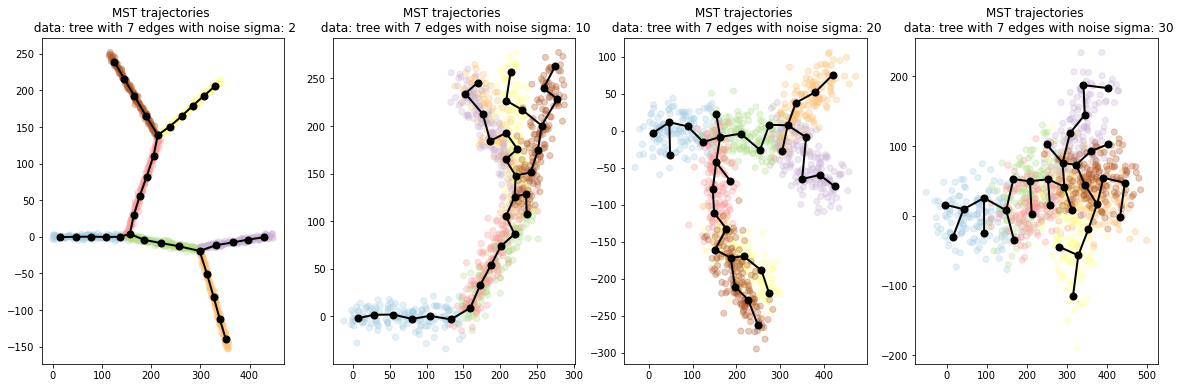

<Figure size 1440x432 with 0 Axes>

In [9]:

fig = plt.figure(figsize=(20, 6))
c = 0
list_sigma_noise = [2,10, 20 ,30  ]
n_subplots_x = len(list_sigma_noise)

for sigma_noise in list_sigma_noise:
    c+=1; fig.add_subplot(1, 4 , c ) 
    X,y = make_multi_level_fork(sigma_noise = sigma_noise, len_tooth=150, n_components = 2, n_levels_of_branching = 3,
                                  inertia_coef = 1, step_from_previous_branch = 0, plot_mode = None, return_X_y = True) 
    
    dict_result =  create_tree_by_cluster_knn_mst(X)# , n_clusters= nodes_number )# - Calcuates a tree for given dataset, by kmeans+knn+mst
    edges =  dict_result['edges_mst']
    nodes_positions = dict_result['nodes_positions']
    plot_graph(edges, nodes_positions, data = X, dim_reduction = 'plot_first2axis', data_transparency_alpha = 0.3 , data_color = y)
    plt.title('MST trajectories \n data: tree with 7 edges with noise sigma: '+str(sigma_noise) )
    if (c%4 == 0) :
        plt.show() 
        fig = plt.figure(figsize=(20, 6))
        c = 0
         
        
plt.show() 

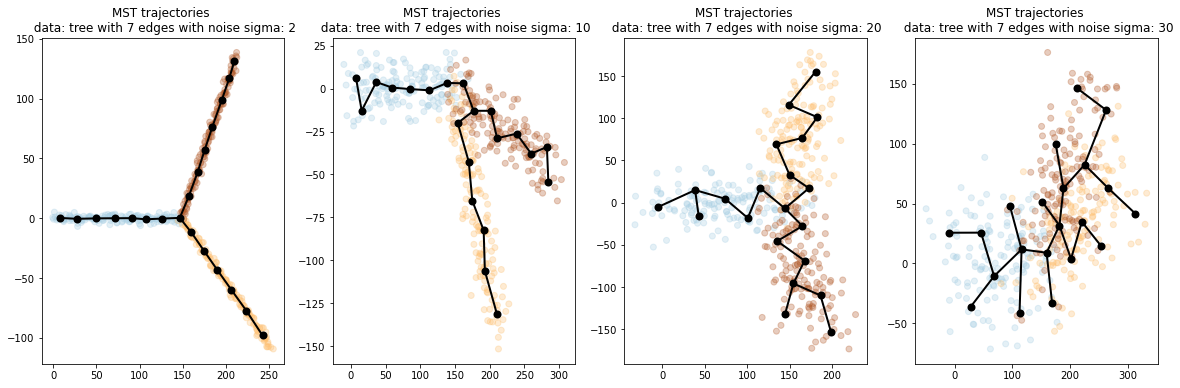

<Figure size 1440x432 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(20, 6))
c = 0
list_sigma_noise = [2,10, 20 ,30  ]
n_subplots_x = len(list_sigma_noise)

for sigma_noise in list_sigma_noise:
    c+=1; fig.add_subplot(1, 4 , c ) 
    X,y = make_multi_level_fork(sigma_noise = sigma_noise, len_tooth=150, n_components = 2, n_levels_of_branching = 2,
                                  inertia_coef = 1, step_from_previous_branch = 0, plot_mode = None, return_X_y = True) 
    
    dict_result =  create_tree_by_cluster_knn_mst(X)# , n_clusters= nodes_number )# - Calcuates a tree for given dataset, by kmeans+knn+mst
    edges =  dict_result['edges_mst']
    nodes_positions = dict_result['nodes_positions']
    plot_graph(edges, nodes_positions, data = X, dim_reduction = 'plot_first2axis', data_transparency_alpha = 0.3 , data_color = y)
    plt.title('MST trajectories \n data: tree with 7 edges with noise sigma: '+str(sigma_noise) )
    if (c%4 == 0) :
        plt.show() 
        fig = plt.figure(figsize=(20, 6))
        c = 0
         
        
plt.show() 